In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from rebound import M_to_f
from rotation_tools import euler_to_quat, quat_to_euler, direction_cosines_euler, direction_cosines_quat

In [3]:
A = 0.314
B = 0.474
C = 0.542
# B = C
e = 0.115
# e = 0
M0 = np.radians(295)
N = 100
P = 2*np.pi
n = 2*np.pi/P
ts = np.arange(0, N*P, P/100)
true_P = 21.28

theta0 = 0.004
phi0 = 1.441
psi0 = 0.427
omega0 = 4.433
omegaa0 = omega0*0.890
omegab0 = omega0*0.067
omegac0 = omega0*0.451
initial_state_ang = [theta0, phi0, psi0, omegaa0, omegab0, omegac0]
lambda0_0, lambda1_0, lambda2_0, lambda3_0 = euler_to_quat(theta0, phi0, psi0)
initial_state_quat = [lambda0_0, lambda1_0, lambda2_0, lambda3_0, omegaa0, omegab0, omegac0]

In [5]:
print(direction_cosines_quat(1, lambda0_0, lambda1_0, lambda2_0, lambda3_0))
print(direction_cosines_euler(1, theta0, phi0, psi0))

(0.5398389348387803, -0.12627512294584, -0.832243064108764)
(0.5398389348387802, -0.12627512294584003, -0.8322430641087639)


In [6]:
def func_3d(t, y, e):
    theta, phi, psi, omegaa, omegab, omegac = y
    M = np.remainder(n*t, 2*np.pi) + M0
    f = M_to_f(e, M)
    r = (1 - e**2)/(1 + e*np.cos(f))

    # alpha = np.cos(theta - f)*np.cos(psi) - np.sin(theta - f)*np.cos(phi)*np.sin(psi)
    # beta = -np.cos(theta - f)*np.sin(psi) - np.sin(theta - f)*np.cos(phi)*np.cos(psi)
    # gamma = np.sin(theta - f)*np.sin(phi)
    alpha, beta, gamma = direction_cosines_euler(f, theta, phi, psi)

    theta_dot = (omegaa*np.sin(psi) + omegab*np.cos(psi))/np.sin(phi)
    phi_dot = omegaa*np.cos(psi) - omegab*np.sin(psi)
    psi_dot = omegac - theta_dot*np.cos(phi)

    omegaa_dot = (B-C)/A*(omegab*omegac - 3*beta*gamma/r**3)
    omegab_dot = (C-A)/B*(omegac*omegaa - 3*gamma*alpha/r**3)
    omegac_dot = (A-B)/C*(omegaa*omegab - 3*alpha*beta/r**3)
    return [theta_dot, phi_dot, psi_dot, omegaa_dot, omegab_dot, omegac_dot]

def func_quat(t, y, e):
    lambda0, lambda1, lambda2, lambda3, omegaa, omegab, omegac = y
    M = np.remainder(n*t, 2*np.pi) + M0
    f = M_to_f(e, M)
    r = (1 - e**2)/(1 + e*np.cos(f))

    lambda0_dot = 0.5*(-lambda1*omegaa - lambda2*omegab - lambda3*omegac)
    lambda1_dot = 0.5*(lambda0*omegaa - lambda3*omegab + lambda2*omegac)
    lambda2_dot = 0.5*(lambda3*omegaa + lambda0*omegab - lambda1*omegac)
    lambda3_dot = 0.5*(-lambda2*omegaa + lambda1*omegab + lambda0*omegac)

    # alpha = (lambda0**2 + lambda1**2 - lambda2**2 - lambda3**2)*np.cos(f) + 2*(lambda0*lambda3 + lambda1*lambda2)*np.sin(f)
    # beta = 2*(lambda1*lambda2 - lambda0*lambda3)*np.cos(f) + (lambda0**2 - lambda1**2 + lambda2**2 - lambda3**2)*np.sin(f)
    # gamma = 2*(lambda0*lambda2 + lambda1*lambda3)*np.cos(f) + 2*(-lambda0*lambda1 + lambda2*lambda3)*np.sin(f)
    # quat_norm_sq = lambda0**2 + lambda1**2 + lambda2**2 + lambda3**2
    # alpha /= quat_norm_sq
    # beta /= quat_norm_sq
    # gamma /= quat_norm_sq
    alpha, beta, gamma = direction_cosines_quat(f, lambda0, lambda1, lambda2, lambda3)
    
    omegaa_dot = (B-C)/A*(omegab*omegac - 3*beta*gamma/r**3)
    omegab_dot = (C-A)/B*(omegac*omegaa - 3*gamma*alpha/r**3)
    omegac_dot = (A-B)/C*(omegaa*omegab - 3*alpha*beta/r**3)

    return [lambda0_dot, lambda1_dot, lambda2_dot, lambda3_dot, omegaa_dot, omegab_dot, omegac_dot]  

def sing_event(t, y, e):
    return np.sin(y[1])
# sing_event.terminal = True

In [7]:
fid_sol_ang = solve_ivp(func_3d, [ts[0], ts[-1]], initial_state_ang, events=sing_event, t_eval=ts, rtol=1e-6, atol=1e-9, args=(e,), method='Radau')
fid_sol_ang.A = A
fid_sol_ang.B = B
fid_sol_ang.C = C

fid_sol_quat = solve_ivp(func_quat, [ts[0], ts[-1]], initial_state_quat, t_eval=ts, rtol=1e-6, atol=1e-9, args=(e,), method='Radau')
fid_sol_quat.A = A
fid_sol_quat.B = B
fid_sol_quat.C = C

In [8]:
theta_quat, phi_quat, psi_quat = quat_to_euler(fid_sol_quat.y[0], fid_sol_quat.y[1], fid_sol_quat.y[2], fid_sol_quat.y[3])

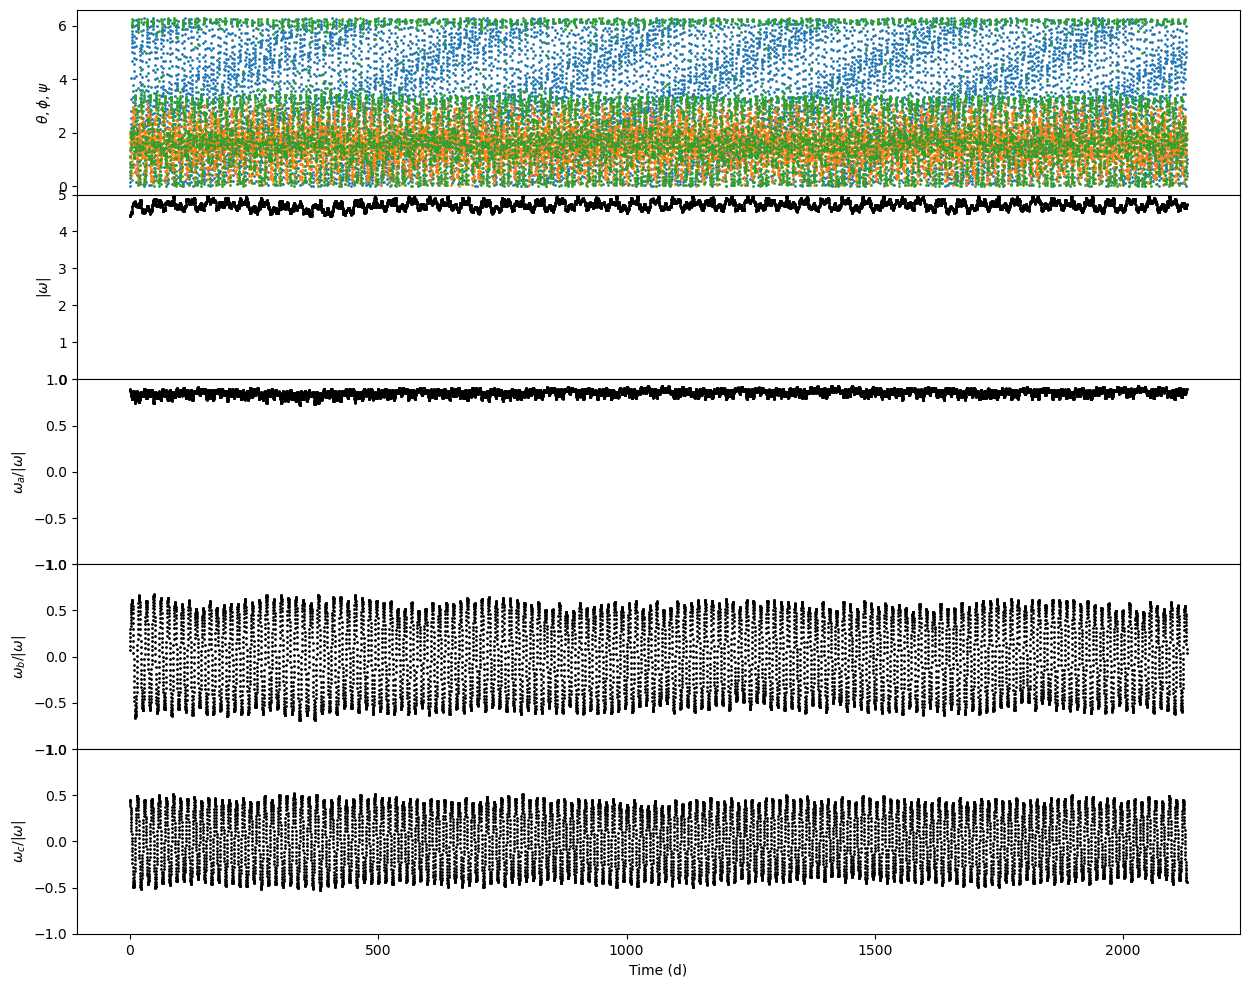

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'hspace': 0})
axs[0].scatter(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[0], 2*np.pi), s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[1], 2*np.pi), s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[2], 2*np.pi), s=1, alpha=1, linestyle='None')
axs[1].scatter(fid_sol_ang.t/(2*np.pi)*true_P, np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[2].scatter(fid_sol_ang.t/(2*np.pi)*true_P, fid_sol_ang.y[3]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[3].scatter(fid_sol_ang.t/(2*np.pi)*true_P, fid_sol_ang.y[4]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[4].scatter(fid_sol_ang.t/(2*np.pi)*true_P, fid_sol_ang.y[5]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
for ax in axs:
    ax.vlines(fid_sol_ang.t_events[0]/(2*np.pi)*true_P, *ax.get_ylim(), color='r', linestyle='--')
axs[0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1].set_ylabel('$|\omega|$')
axs[2].set_ylabel('$\omega_a/|\omega|$')
axs[3].set_ylabel('$\omega_b/|\omega|$')
axs[4].set_ylabel('$\omega_c/|\omega|$')
axs[4].set_xlabel('Time (d)')
axs[1].set_ylim(0, 5)
for ax in axs[2:]:
    ax.set_ylim(-1, 1)
# axs[0].set_ylim(-10, 10)
# axs[2].set_ylim(0, 30)
# plt.xlim(0, 40)

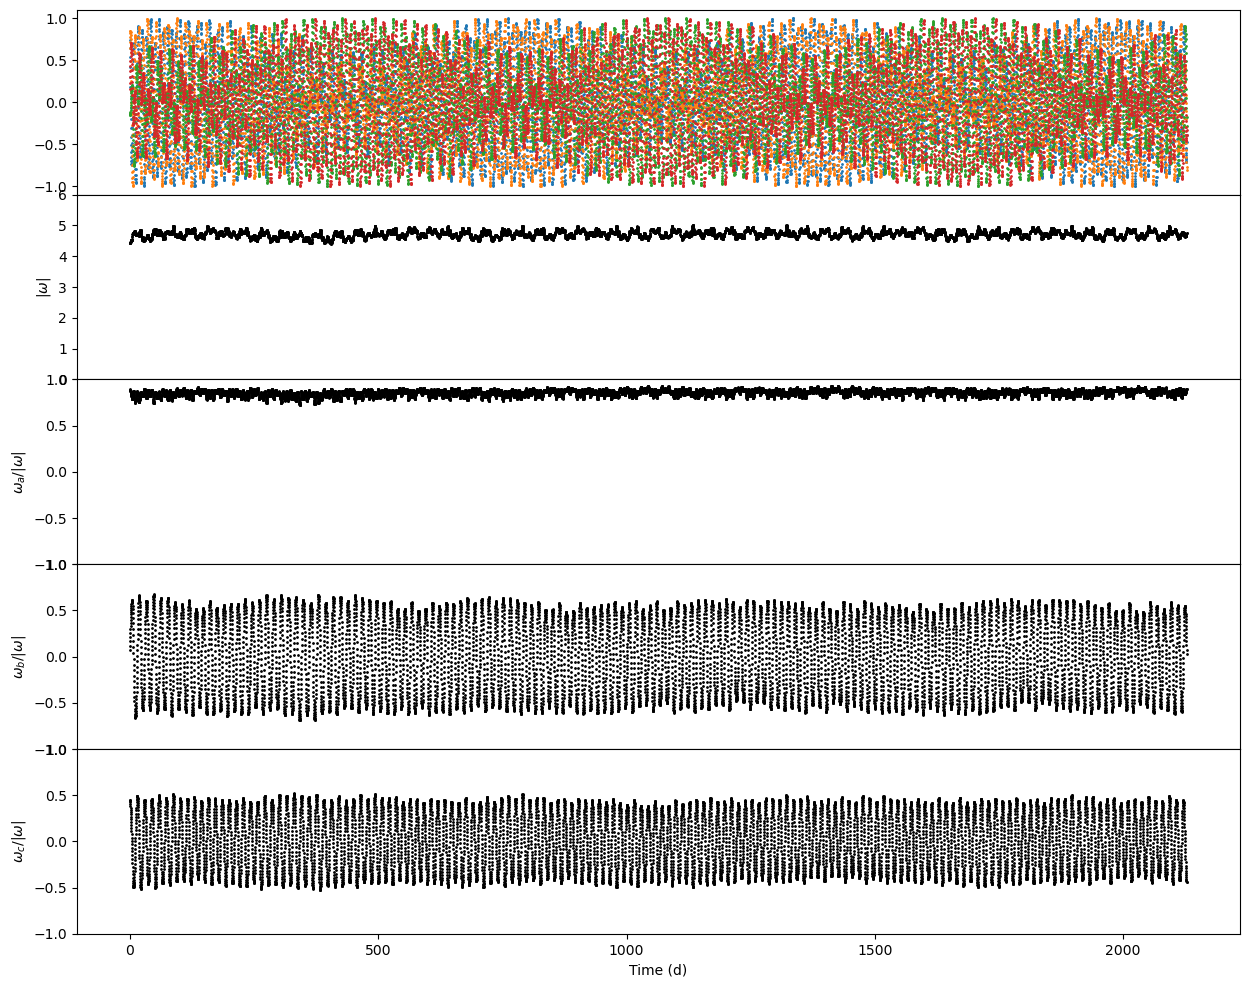

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'hspace': 0})
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[0], s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[1], s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[2], s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[3], s=1, alpha=1, linestyle='None')
axs[1].scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.linalg.norm(fid_sol_quat.y[4:], axis=0), s=1, alpha=1, color='k')
axs[2].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[4]/np.linalg.norm(fid_sol_quat.y[4:], axis=0), s=1, alpha=1, color='k')
axs[3].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[5]/np.linalg.norm(fid_sol_quat.y[4:], axis=0), s=1, alpha=1, color='k')
axs[4].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[6]/np.linalg.norm(fid_sol_quat.y[4:], axis=0), s=1, alpha=1, color='k')
# for ax in axs:
    # ax.vlines(fid_sol_quat.t_events[0]/(2*np.pi)*true_P, *ax.get_ylim(), color='r', linestyle='--')
# axs[0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1].set_ylabel('$|\omega|$')
axs[2].set_ylabel('$\omega_a/|\omega|$')
axs[3].set_ylabel('$\omega_b/|\omega|$')
axs[4].set_ylabel('$\omega_c/|\omega|$')
axs[4].set_xlabel('Time (d)')
axs[1].set_ylim(0, 6)
for ax in axs[2:]:
    ax.set_ylim(-1, 1)
# axs[0].set_ylim(-10, 10)
# axs[2].set_ylim(0, 30)
# plt.xlim(0, 40)

Text(0.5, 0, 'Time (d)')

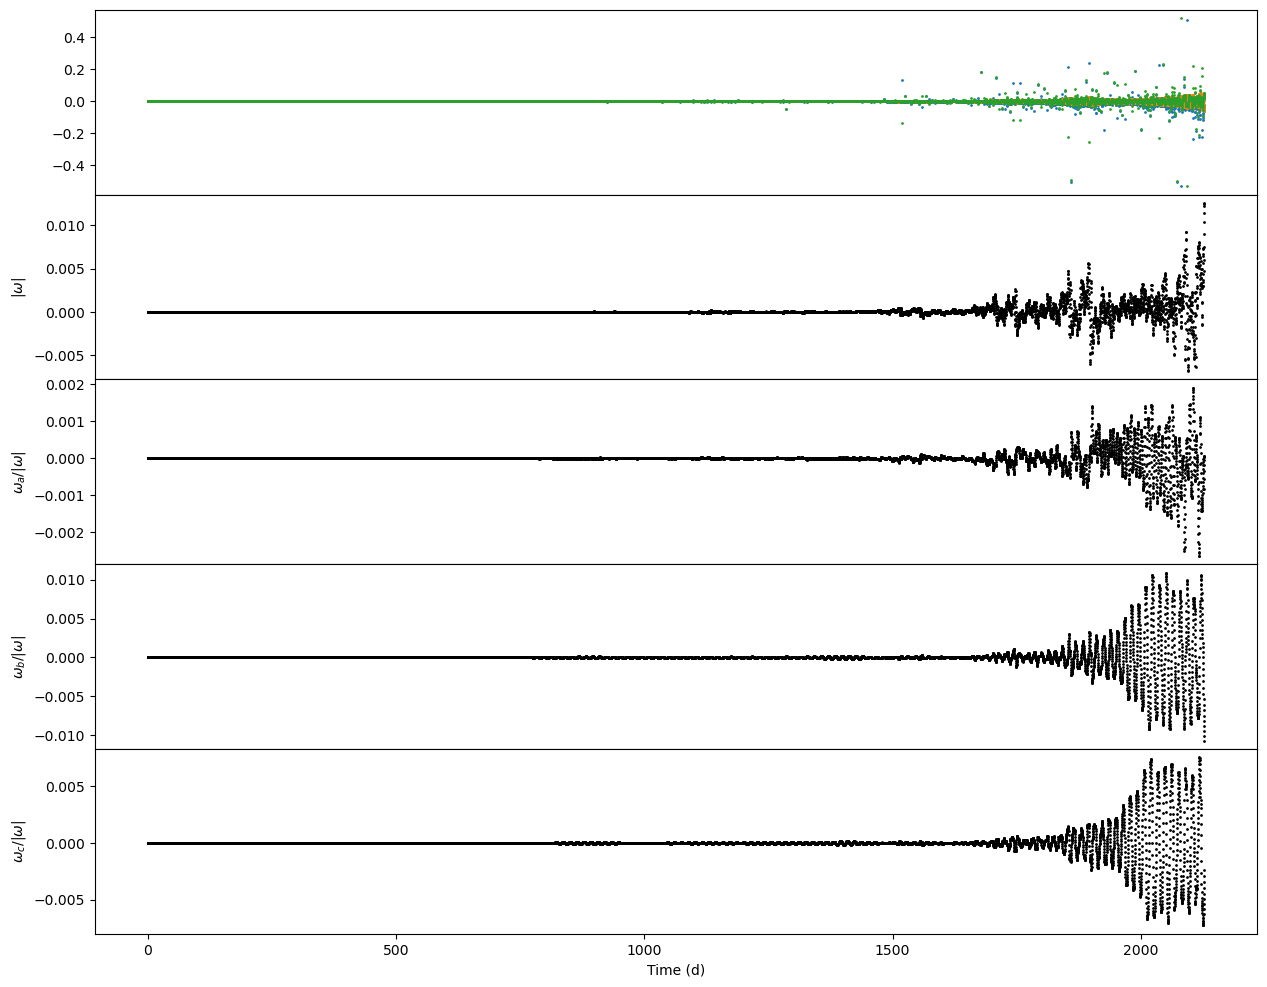

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'hspace': 0})
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[0] - theta_quat - np.pi, 2*np.pi) - np.pi, s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[1] - phi_quat - np.pi, 2*np.pi) - np.pi, s=1, alpha=1, linestyle='None')
axs[0].scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[2] - psi_quat - np.pi, 2*np.pi) - np.pi, s=1, alpha=1, linestyle='None')
axs[1].scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.linalg.norm(fid_sol_quat.y[4:], axis=0) - np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[2].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[4]/np.linalg.norm(fid_sol_quat.y[4:], axis=0) - fid_sol_ang.y[3]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[3].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[5]/np.linalg.norm(fid_sol_quat.y[4:], axis=0) - fid_sol_ang.y[4]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
axs[4].scatter(fid_sol_quat.t/(2*np.pi)*true_P, fid_sol_quat.y[6]/np.linalg.norm(fid_sol_quat.y[4:], axis=0) - fid_sol_ang.y[5]/np.linalg.norm(fid_sol_ang.y[3:], axis=0), s=1, alpha=1, color='k')
# for ax in axs:
    # ax.vlines(fid_sol_quat.t_events[0]/(2*np.pi)*true_P, *ax.get_ylim(), color='r', linestyle='--')
# axs[0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1].set_ylabel('$|\omega|$')
axs[2].set_ylabel('$\omega_a/|\omega|$')
axs[3].set_ylabel('$\omega_b/|\omega|$')
axs[4].set_ylabel('$\omega_c/|\omega|$')
axs[4].set_xlabel('Time (d)')
# axs[1].set_ylim(0, 6)
# for ax in axs[2:]:
    # ax.set_ylim(-1, 1)
# axs[0].set_ylim(-10, 10)
# axs[2].set_ylim(0, 30)
# plt.xlim(0, 40)

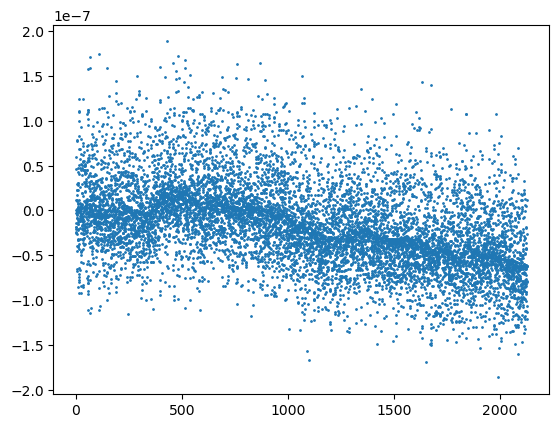

In [12]:
plt.scatter(fid_sol_quat.t/(2*np.pi)*true_P, np.linalg.norm(fid_sol_quat.y[0:4], axis=0) - 1, s=1)
# plt.yscale('log')

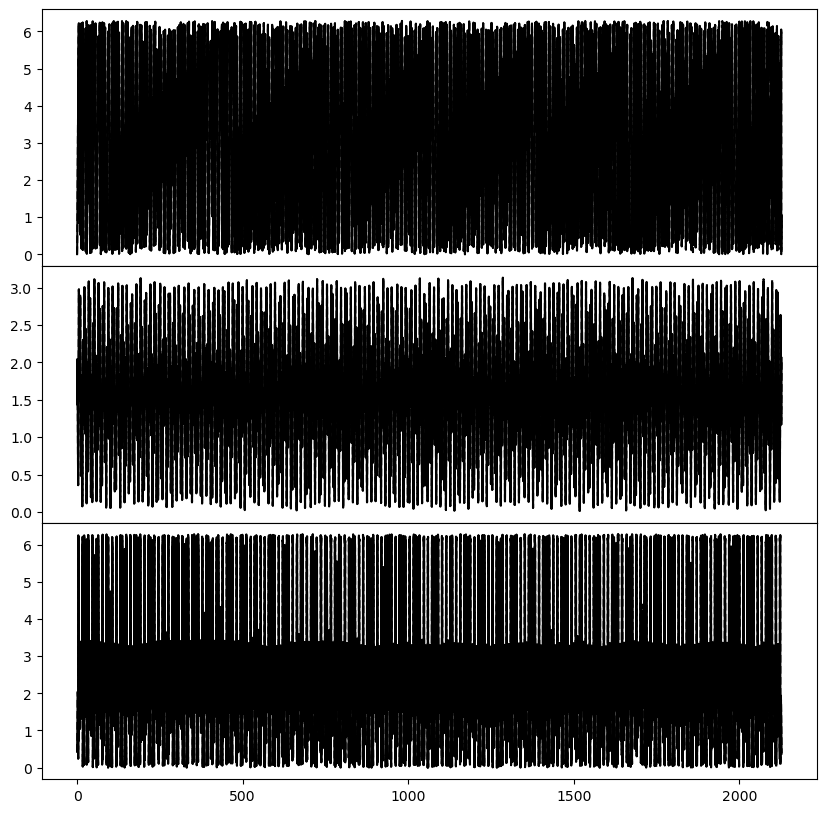

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[0], 2*np.pi), color='k', linestyle='--')
axs[0].plot(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(theta_quat, 2*np.pi), color='k')
axs[1].plot(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[1], 2*np.pi), color='k', linestyle='--')
axs[1].plot(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(phi_quat, 2*np.pi), color='k')
axs[2].plot(fid_sol_ang.t/(2*np.pi)*true_P, np.remainder(fid_sol_ang.y[2], 2*np.pi), color='k', linestyle='--')
axs[2].plot(fid_sol_quat.t/(2*np.pi)*true_P, np.remainder(psi_quat, 2*np.pi), color='k')

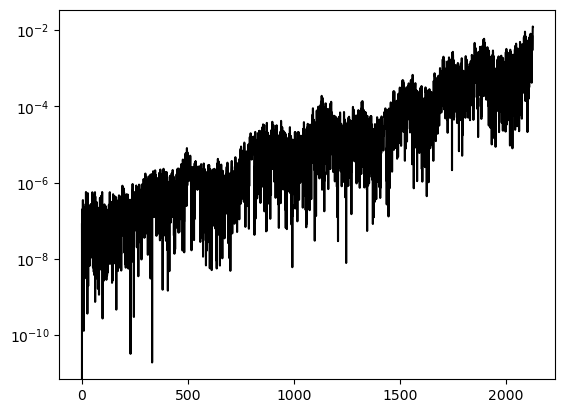

In [14]:
plt.plot(fid_sol_quat.t/(2*np.pi)*true_P, np.abs(np.linalg.norm(fid_sol_quat.y[4:], axis=0) - np.linalg.norm(fid_sol_ang.y[3:], axis=0)), color='k')
plt.yscale('log')
# plt.ylim(1e-5, 1e1)

In [ ]:
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(fid_sol_quat.y[0], fs=1/(fid_sol_quat.t[1] - fid_sol_quat.t[0]), nperseg=1000, noverlap=900)
plt.pcolormesh(t, f, Sxx)
plt.ylim(0, 1)

In [ ]:
f, t, Sxx = spectrogram(fid_sol_quat.y[1], fs=1/(fid_sol_quat.t[1] - fid_sol_quat.t[0]), nperseg=1000, noverlap=900)
plt.pcolormesh(t, f, Sxx)
plt.ylim(0, 1)

In [ ]:
f, t, Sxx = spectrogram(fid_sol_quat.y[2], fs=1/(fid_sol_quat.t[1] - fid_sol_quat.t[0]), nperseg=1000, noverlap=900)
plt.pcolormesh(t, f, Sxx)
plt.ylim(0, 1)

In [ ]:
f, t, Sxx = spectrogram(fid_sol_quat.y[3], fs=1/(fid_sol_quat.t[1] - fid_sol_quat.t[0]), nperseg=1000, noverlap=900)
plt.pcolormesh(t, f, Sxx)
plt.ylim(0, 1)